# Retail Recommendation Engine
------------

## Introduction


A *recommendation engine*, also known as a *recommender system*, is a software that analyzes available data to make suggestions for something that an user might be interested in, such as a book, a grocery item, movies or a job, among other possibilities.

In this notebook, we will be going through the steps involved in creating a recommendation engine for an online retail shop, along with testing and deployment.

**![List item](https://raw.githubusercontent.com/sudeeshsukumaran/RetailRecommendationEngine/master/image/shop.jpg)**

In retail industry, the recommender system, uses the data, to train itself, to identify the items that are frequently bought along with the items that are already picked. This can be used both for *online retail* or in a *physical store*. In physical store, the information provided by this system, can be used to arrange the items on the shelf so that the sales of those frequently bought together items can be increased.

#### Libraries
The following libraries will be used for this project.

**PS**:* If the import fails, please install the appropriate modules using PIP install, before proceeding further.*




In [1]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from datetime import datetime
#from community import community_louvain

from mlxtend.frequent_patterns import apriori, association_rules # APRIORI algo library

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



### Source Dataset

For This Project, We Will Be Using The Online Retail Dataset, From Uci Repository; [Online-Retail](Http://Https://Archive.Ics.Uci.Edu/Ml/Datasets/Online+Retail).

*The excel downloaded from UCI, has two tabs in it. This case study uses data from 2010 - 2011 tab.*

A copy of which is stored in my github.

In [2]:
#Import data set
df_in = pd.read_excel("https://raw.githubusercontent.com/sudeeshsukumaran/RetailRecommendationEngine/master/DSET/online_retail.xlsx")

###  Exploratory Data Analysis
Lets analyse the data and see, if it needs any further processing / cleansing, before we use it in our algorithm.

In [3]:
df_in.shape

(541910, 8)

In [4]:
df_in.describe()

,Quantity,Price,CustomerID
count,541910.000000,541910.000000,406830.000000
mean,9.552234,4.611138,15287.684160
std,218.080957,96.759765,1713.603074
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
df_in.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
# Min, Max dates in the dataframe
print("Min timestamp in the dataset is ",  df_in.InvoiceDate.min())
print("Max timestamp in the dataset is ",  df_in.InvoiceDate.max())

Min timestamp in the dataset is  2010-12-01 08:26:00
Max timestamp in the dataset is  2011-12-09 12:50:00


In [7]:
# Number of invoices in the dataframe
print("Number of Invoices in the dataframe = ", len(df_in.Invoice.unique()))

Number of Invoices in the dataframe =  25900


In [8]:
df_in.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
CustomerID     135080
Country             0
dtype: int64

In [9]:
# Count number of invoices that do not have customer id
l1=df_in['Invoice'][df_in['CustomerID'].isnull()]
print("Number of invoices that do not have customer id = ", len(l1.unique()))


Number of invoices that do not have customer id =  3710


In [10]:
len(df_in['Country'].unique())

38

In [11]:
df_in['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

<BarContainer object of 10 artists>

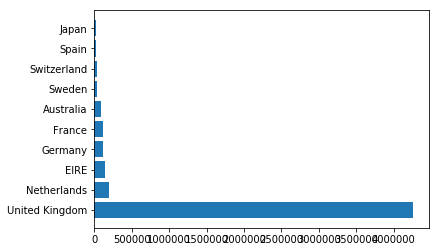

In [12]:
new_df = df_in.groupby(['Country'])['Quantity'].sum().reset_index()
new_df = new_df.sort_values(by = ['Quantity'], ascending=False)
x = new_df['Country'].head(10)
y = new_df['Quantity'].head(10) #.plot.barh
plt.barh(x,y)

In [13]:
print("Most items shipped to UK, number of items")
print(new_df[new_df['Country'] == "United Kingdom"])
print("\nSecond most items shipped to UK, number of items")
print(new_df[new_df['Country'] == "Netherlands"])

Most items shipped to UK, number of items
           Country  Quantity
36  United Kingdom   4263829

Second most items shipped to UK, number of items
        Country  Quantity
24  Netherlands    200128


In [14]:
# Postage as items
print("Number of postage as items in the invoices = ", df_in['Invoice'][df_in['Description'] == 'POSTAGE'].count())

Number of postage as items in the invoices =  1253


In [15]:
# Postage as items
print("Number of mailout as items in the invoices = ", df_in['Invoice'][df_in['Description'] == 'mailout'].count())

Number of mailout as items in the invoices =  3


In [16]:
# Postage as items
print("Number of Returns = ", df_in['Invoice'][df_in['Quantity'] < 0].count())

Number of Returns =  10624


The dataset contains **541,910** rows and **8** columns / features.
Following columns are present in dataframe:
1. 		*Invoice*
2. 		*StockCode*
3. 		*Description*
4. 		*Quantity*
5. 		*InvoiceDate*
6. 		*Price*
7. 		*CustomerID*
8. 		*Country*

The dataset  :
- has invoices from **2010-12-01** till **2011-12-09**
- has **25,900** unique invoices
- has **1454** null values in the **Description** field
- has **135,080** nulls **customer id** field
- has customers, who are from **38** different **countries**
- has **most items shipped to UK** based customers. Items more than **4M** has shipped to UK customers. Items to other countries are very negligible, second most number of  quantity is **200K**, shipped to **Netherlands**.
- has **1253** records that are for Postage, which we can remove.
- has **10K** records that have negative quantity, probably returns, which we can ignore as well.


### Data Pre-Processing
From our data analysis, we will:
- **fix null description records**, either, using it from other records or by dropping them
- **remove 'Postage'** records
- **remove 'mailout'** records
- remove refund items with **Quantity < 0**


### Functions
The data pre-processing steps need to be repeated, if we are going to load new invoices and create new rulesets. Hence making the steps as functions. so we can call them, when needed instead of re-coding.

In [17]:
# Clean Description Field
#        1. Use the description from other rows using StockCode
#        2. Delete rows where we are not able to find desc, using stockcode

def fix_null_desc():
    # StockCode Description CrossWalk
    print("\nFixing Null Values for Description field....")
    ticw = pd.notnull(df['Description'])# ----> Creates a series with 'True', if not null values in Description,
                                        #                             'False' if null values.

    icw = df[ticw] # ----> Create a lookup with not null description
    labels=list(df.columns)
    labels.remove('StockCode')
    labels.remove('Description')
    labels
    icw=icw.drop(columns=labels)
    
    icwd=icw.drop_duplicates(subset='StockCode') #----> Store only Unique StockCodes and its descriptions
    
    c1=df['Description'].isnull().sum()

    df['Description'] = df['StockCode'].map(icwd.set_index('StockCode')['Description']) # --> Use the lookup to replace nulls with available descriptions.
    
    c2=df['Description'].isnull().sum()

    print('Null values are replaced with existing descriptions with same StockCode: Count = ', c1 - c2)
    
    df.drop(df[df['Description'].isnull()].index,inplace=True)
    
    c3=df['Description'].isnull().sum()

    print('Rows with null value Descriptions are dropped after lookup failed to match description: Count = ', c2 - c3)
    
    return
    

In [18]:
# Remove Postage records

def drop_postage():
    
    print("\nDropping POSTAGE as items from the invoices....")

    b1 = len(df['Description'] == "POSTAGE")
    df.drop(df[df['Description'] == "POSTAGE"].index,inplace=True)
    b2 = len(df['Description'] == "POSTAGE")
    print("Number of records, with POSTAGE as Description, dropped = ", b1 - b2)
    return()

In [19]:
# Remove Postage records

def drop_mailout():
    
    print("\nDropping mailout as items from the invoices....")

    b1 = len(df['Description'] == "mailout")
    df.drop(df[df['Description'] == "mailout"].index,inplace=True)
    b2 = len(df['Description'] == "mailout")
    print("Number of records, with mailout as Description, dropped = ", b1 - b2)
    return()

In [20]:
# Remove Postage records

def remove_refund():
    
    print("\nRemoving Refund Entries from Invoice....")

    b1 = len(df['Quantity'] < 0)
    df.drop(df[df['Quantity'] < 0].index,inplace=True)
    b2 = len(df['Quantity'] < 0)
    print("Number of records, with Quantity < 0, dropped = ", b1-b2)
    return()

In [21]:
# Defining the hot encoding function to make the data suitable for the concerned libraries 
def hot_encode(x): 
    if(x<= 0): 
        return 0
    if(x>= 1): 
        return 1

In [22]:
def first_time_build():
    print("\nRecommendation System initial build started..",datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    basket = (df 
          .groupby(['Invoice', 'Description'])['Quantity'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('Invoice'))
    
    basket_encoded = basket.applymap(hot_encode)
    basket = basket_encoded
    
    print("\nData encoding completed..",datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    print("\nApriori Model building - Started: ", datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    
    # Building the model
    frq_items = apriori(basket, min_support = 0.02, use_colnames = True)
    
    print("Apriori Model building - Completed: ", datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    print("\nAssociation rules build Started:", datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    
    # Collecting the inferred rules in a dataframe
    rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
    rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
    rules.head()
    print("Association rules build completed:", datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    
    rules["str_antecedents"] = rules["antecedents"].apply(lambda x: list(x)[0]).astype("unicode")
    rules["str_consequents"] = rules["consequents"].apply(lambda x: list(x)[0]).astype("unicode")
    
    sh1=rules.shape
    print("\nNumber of Rules Created = ", sh1[0])

    return rules

In [23]:
def subsequent_time_build(rules):
    print("\nRecommendation System update started..",datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    basket = (df 
          .groupby(['Invoice', 'Description'])['Quantity'] 
          .sum().unstack().reset_index().fillna(0)
          .set_index('Invoice'))
    
    basket_encoded = basket.applymap(hot_encode)
    basket = basket_encoded
    
    print("\nData encoding completed..",datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    print("\nApriori Model building - Started: ", datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    
    # Building the model
    frq_items = apriori(basket, min_support = 0.02, use_colnames = True)
    
    print("Apriori Model building - Completed: ", datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    print("\nAssociation rules build Started:", datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    
    # Collecting the inferred rules in a dataframe
    rules_sub = association_rules(frq_items, metric ="lift", min_threshold = 1)
    rules_sub["str_antecedents"] = rules_sub["antecedents"].apply(lambda x: list(x)[0]).astype("unicode")
    rules_sub["str_consequents"] = rules_sub["consequents"].apply(lambda x: list(x)[0]).astype("unicode")
    
    sh=rules_sub.shape
    
    rules = rules.append(rules_sub)
    rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])

    print("Association rules build completed:", datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
    print("Number of rules updated = ", sh[0])
    
    sh=rules.shape
    print("\n")
    print("Total Number of rules available = ", sh[0])
    return rules

### Execution & Creating the Engine
After we compiled our functions, lets execute the steps in right sequence to do pre-processing and create the engine.

In [24]:
df = df_in.copy()

fix_null_desc()
drop_postage()
drop_mailout()
remove_refund()

rules_df=first_time_build()


Fixing Null Values for Description field....
Null values are replaced with existing descriptions with same StockCode: Count =  1342
Rows with null value Descriptions are dropped after lookup failed to match description: Count =  112

Dropping POSTAGE as items from the invoices....
Number of records, with POSTAGE as Description, dropped =  1257

Dropping mailout as items from the invoices....
Number of records, with mailout as Description, dropped =  3298

Removing Refund Entries from Invoice....
Number of records, with Quantity < 0, dropped =  10367

Recommendation System initial build started.. 02-02-2021 13:14:57

Data encoding completed.. 02-02-2021 13:16:07

Apriori Model building - Started:  02-02-2021 13:16:07


MemoryError: Unable to allocate 11.7 GiB for an array with shape (37950, 2, 20626) and data type int64

Following is the network graph for the association rules created.

In [ ]:
import networkx as nx
rules_df.antecedents  =  rules_df.antecedents.apply(lambda x: next(iter(x)))
rules_df.consequents  =  rules_df.consequents.apply(lambda x: next(iter(x)))
fig, ax = plt.subplots(figsize = (15,6))
GA = nx.from_pandas_edgelist(rules_df,source = 'antecedents',target = 'consequents')
nx.draw(GA,with_labels = True)

### Testing
Now that we built the model, lets test the recommendation using "***PINK REGENCY TEACUP AND SAUCER***" as an item in our cart.


In [ ]:
cart = "RED RETROSPOT CHARLOTTE BAG"
recomm_list=rules_df['str_consequents'][rules_df['str_antecedents'] == cart].unique()
re_list = " "

for i in range(len(recomm_list)):
    cnt = len(recomm_list) - 1
    if i < cnt:
        re_list = re_list + (recomm_list[i]) + ", "
    else:
        re_list = re_list + "& " + (recomm_list[i])
        
print("Customers who bought {}, also bought{}".format(cart,re_list))

**Result**: When the item "Pink Regency Teacup and Saucer" is added the engine recommends to buy "Green Regency Teacup And Saucer, & Roses Regency Teacup And Saucer".

### Maintenance

When the retail shop continues its online presence using this recommendation algorithm, it is necessary that we update new invoice data regularly so that association rules are updated frequently and recommendation actualy makes some sense, in buying items together.

In the original data from the UCI repository, there is a tab that has data for 2009. We will load the data ad update the rules that we just created.


In [ ]:
#Import data set
df_in2 = pd.read_excel("https://raw.githubusercontent.com/sudeeshsukumaran/RetailRecommendationEngine/master/DSET/online_retail_b.xlsx")

We will be using the same steps that we create the initial rules. Once the rules are created, we will update the new rules to the existing rules.

In [ ]:
df = df_in2.copy()

fix_null_desc()
drop_postage()
drop_mailout()
remove_refund()

rules_df=subsequent_time_build(rules_df)

In [ ]:
rules_df.head()

### Testing

Let's test the new rules.

In [ ]:
cart = "RED RETROSPOT CHARLOTTE BAG"
recomm_list=rules_df['str_consequents'][rules_df['str_antecedents'] == cart].unique()
re_list = " "

for i in range(len(recomm_list)):
    cnt = len(recomm_list) - 1
    if i < cnt:
        re_list = re_list + (recomm_list[i]) + ", "
    else:
        re_list = re_list + "& " + (recomm_list[i])
        
print("Customers who bought {}, also bought{}".format(cart,re_list))

#### Thank You